In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

plt.style.use('default')

## EDA

In [2]:
# load data -store1.csv
store1 = pd.read_csv("../store1.csv")

In [3]:
store1.head()

,Unnamed: 0,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
# get the max and min date for every family
store1.groupby('family').agg({'date':['min','max', 'count'], 'sales':'sum'})


date                           sales
                                   min         max count           sum
family                                                                
AUTOMOTIVE                  2013-01-01  2017-08-15  1684  5.475000e+03
BABY CARE                   2013-01-01  2017-08-15  1684  0.000000e+00
BEAUTY                      2013-01-01  2017-08-15  1684  4.056000e+03
BEVERAGES                   2013-01-01  2017-08-15  1684  2.673769e+06
BOOKS                       2013-01-01  2017-08-15  1684  2.110000e+02
BREAD/BAKERY                2013-01-01  2017-08-15  1684  5.699922e+05
CELEBRATION                 2013-01-01  2017-08-15  1684  1.678600e+04
CLEANING                    2013-01-01  2017-08-15  1684  1.078525e+06
DAIRY                       2013-01-01  2017-08-15  1684  1.054354e+06
DELI                        2013-01-01  2017-08-15  1684  2.070371e+05
EGGS                        2013-01-01  2017-08-15  1684  2.365060e+05
FROZEN FOODS                2013-01-01  2017-08-15  1684  2.179264e+05
GROCERY I                   2013-01-01  2017-08-15  1684  3.743823e+06
GROCERY II                  2013-01-01  2017-08-15  1684  3.678300e+04
HARDWARE                    2013-01-01  2017-08-15  1684  2.694000e+03
HOME AND KITCHEN I          2013-01-01  2017-08-15  1684  2.500600e+04
HOME AND KITCHEN II         2013-01-01  2017-08-15  1684  2.179600e+04
HOME APPLIANCES             2013-01-01  2017-08-15  1684  5.690000e+02
HOME CARE                   2013-01-01  2017-08-15  1684  1.700620e+05
LADIESWEAR                  2013-01-01  2017-08-15  1684  1.583500e+04
LAWN AND GARDEN             2013-01-01  2017-08-15  1684  1.516900e+04
LINGERIE                    2013-01-01  2017-08-15  1684  1.131400e+04
LIQUOR,WINE,BEER            2013-01-01  2017-08-15  1684  1.701110e+05
MAGAZINES                   2013-01-01  2017-08-15  1684  5.399000e+03
MEATS                       2013-01-01  2017-08-15  1684  5.276083e+05
PERSONAL CARE               2013-01-01  2017-08-15  1684  2.175340e+05
PET SUPPLIES                2013-01-01  2017-08-15  1684  5.850000e+03
PLAYERS AND ELECTRONICS     2013-01-01  2017-08-15  1684  8.913000e+03
POULTRY                     2013-01-01  2017-08-15  1684  4.786214e+05
PREPARED FOODS              2013-01-01  2017-08-15  1684  1.359796e+05
PRODUCE                     2013-01-01  2017-08-15  1684  2.443330e+06
SCHOOL AND OFFICE SUPPLIES  2013-01-01  2017-08-15  1684  2.890000e+02
SEAFOOD                     2013-01-01  2017-08-15  1684  4.368901e+04

In [5]:
from datetime import date

start = date(2013, 1, 1)
end = date(2017, 8, 15)
delta = end - start
print(delta.days)

1687


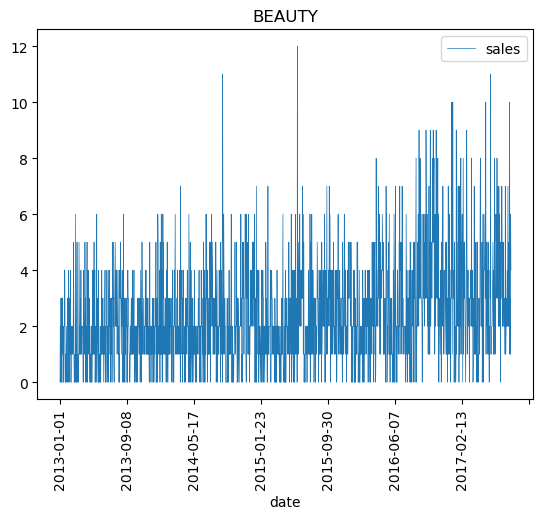

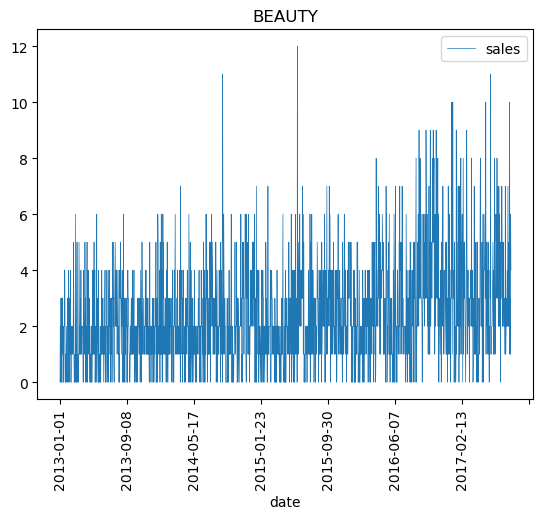

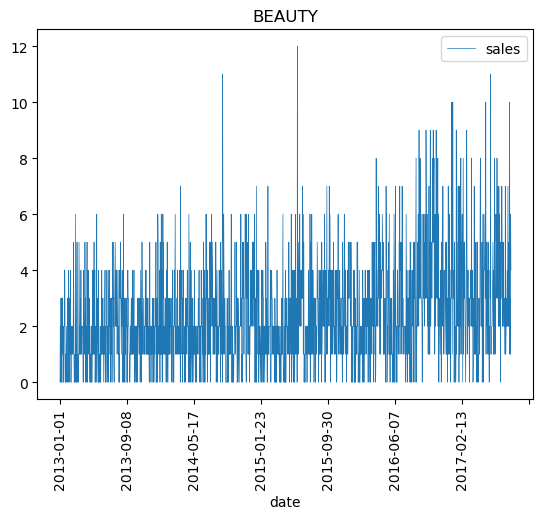

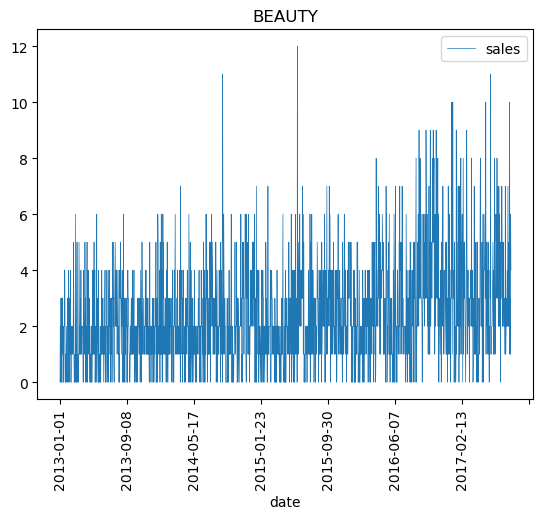

In [6]:
#plot whole sales for few family 
for family in store1['family'].unique()[2:6]:
    family = store1['family'].unique()[2]
    store1[store1['family']==family].plot(x='date',y='sales',title=family,linewidth=0.5)
    plt.xticks(rotation=90)
    plt.show()

## Podział na zbiór treningowy i testowy

In [7]:
# train test split - test from ('2017-08-07') (last whole week)
split_date = '2017-08-07'
train = store1.loc[store1['date'] < split_date].copy()
# test date from 2017-08-07 to 2017-08-14
test = store1.loc[(store1['date'] >= split_date) & (store1['date'] < "2017-08-14")].copy()

train['date'] = pd.to_datetime(train['date'])  # Convert 'date' column to datetime format
test['date'] = pd.to_datetime(test['date'])  # Convert 'date' column to datetime format

print("Pierwsza data zbioru treningowego: ", train['date'].min(), train['date'].min().strftime('%A'))
print("Ostatnia data zbioru treningowego: ",train['date'].max(), train['date'].max().strftime('%A'))
print("Pierwsza data zbioru testowego: ", test['date'].min(), test['date'].min().strftime('%A'))
print("Ostatnia data zbioru testowego: ", test['date'].max(), test['date'].max().strftime('%A'))


Pierwsza data zbioru treningowego:  2013-01-01 00:00:00 Tuesday
Ostatnia data zbioru treningowego:  2017-08-06 00:00:00 Sunday
Pierwsza data zbioru testowego:  2017-08-07 00:00:00 Monday
Ostatnia data zbioru testowego:  2017-08-13 00:00:00 Sunday


Najlepszy model zostanie wybrany na podstawie hisotrycznej prognozy - od dnia 2017-07-10 wykonujemy prognoze na 7 dni raz na 7 dni - łącznie sa to 4 prognozy.
Na podstawie porównania tych prognoz z faktyczną sprzdażą zostanie wybrany najlepszy model, który to następnie posłuży do zaprognozownia sprzedaży na okres testowy.

## MODELE LOKALNE

In [8]:
from darts import TimeSeries
from darts.models import NaiveSeasonal
from darts.metrics import mse

In [9]:
# create time series for every family
y_sku = TimeSeries.from_group_dataframe(train,
                                        group_cols='family',
                                        time_col='date',
                                        value_cols='sales',
                                        fill_missing_dates=True,
                                        freq='D',
                                        fillna_value=0)

In [10]:
backtest_start_date = pd.Timestamp('2017-07-10')

### Naiwny - powtarzamy ostatnią sprzedaż

In [11]:
backtest_naive = {
    y_sku[number].static_covariates['family'].values[0]: 
    NaiveSeasonal().backtest(series = time_series, start=backtest_start_date, forecast_horizon=7, stride=7, verbose=True, metric = mse)
    for (number, time_series) in enumerate(y_sku)}

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
rmse_backtest_naive = np.sqrt(sum(backtest_naive.values()))
print(f"RMSE for Naive forecast: {rmse_backtest_naive}")

RMSE for Naive forecast: 2490.1151864809485


### Naiwny -  powtarzamy średnią z ostatnich 7 dni

In [13]:
from darts.models import NaiveMean

In [14]:
backtest_naivemean = {
    y_sku[number].static_covariates['family'].values[0]: 
    NaiveMean().backtest(series = time_series, train_length=7, start=backtest_start_date, forecast_horizon=7, stride=7, verbose=True, metric = mse)
    for (number, time_series) in enumerate(y_sku)}

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
rmse_backtest_naivemean = np.sqrt(sum(backtest_naivemean.values()))
print(f"RMSE for Naive forecast: {rmse_backtest_naivemean}")

RMSE for Naive forecast: 1199.2662301669761


In [16]:
historical_naivemean = {
    y_sku[number].static_covariates['family'].values[0]: 
    NaiveMean().historical_forecasts(series = time_series, train_length=7, start=backtest_start_date, forecast_horizon=7, stride=7, verbose=True)
    for (number, time_series) in enumerate(y_sku)}

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

## MODELE GLOBALNE

In [17]:
from darts.models import LightGBMModel

In [18]:
# future covariates - onpromotion
future_cov_all = TimeSeries.from_group_dataframe(store1, # uzywamy stro1, bo mamy tam wszystkie wartosci onpromotion
                                                 group_cols='family',
                                                 time_col='date',
                                                 value_cols='onpromotion',
                                                 fill_missing_dates=True,
                                                 freq='D',
                                                 fillna_value=0)

In [19]:
from darts.dataprocessing.transformers import StaticCovariatesTransformer

transformer = StaticCovariatesTransformer()
y_sku_t = transformer.fit_transform(y_sku)

### LightGBMModel

In [20]:
lgbm_model = LightGBMModel(
    lags=7,
    # lags_past_covariates=0,
    lags_future_covariates=[0],
    add_encoders={
        "cyclic": {"future": ["dayofweek", "month", "weekofyear", "quarter"]}
    },
    output_chunk_length=1, # jezeli używamy lagi to bedziemy konsumowac własne prognozy jezeli forecast_horizon > output_chunk_length
    verbose=-1
)


In [21]:
backtest_lgbm = lgbm_model.backtest(series = y_sku_t, future_covariates=future_cov_all,  start=backtest_start_date, forecast_horizon=7, stride=7, verbose=True, metric = mse)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/33 [00:00<?, ?it/s]

In [22]:
rmse_backtest_lgbm = np.sqrt(sum(backtest_lgbm))
print(f"RMSE for LGBM forecast: {rmse_backtest_lgbm}")

RMSE for LGBM forecast: 514.4092739449106


### Random Forest

In [23]:
# Random Forest
from darts.models import RandomForest
rf_model = RandomForest(
    lags=7,
    lags_future_covariates=[0],
    add_encoders={
        "cyclic": {"future": ["dayofweek", "month", "weekofyear", "quarter"]}
    },
    output_chunk_length=1,
    n_estimators=10
    # criterion="absolute_error",
)

In [24]:
backtest_rf = rf_model.backtest(series = y_sku_t, future_covariates=future_cov_all,  start=backtest_start_date, forecast_horizon=7, stride=7, verbose=True, metric = mse)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/33 [00:00<?, ?it/s]

In [25]:
rmse_backtest_rf = np.sqrt(sum(backtest_rf))
print(f"RMSE for RandomForest forecast: {rmse_backtest_rf}")

RMSE for RandomForest forecast: 473.74478028204106


### XGBoost

In [26]:
from darts.models import XGBModel
xgb_model = XGBModel(
    lags=7,
    lags_future_covariates=[0],
    add_encoders={
        "cyclic": {"future": ["dayofweek", "month", "weekofyear", "quarter"]}
    },
    output_chunk_length=1,
)
backtest_xgb = xgb_model.backtest(series = y_sku_t, future_covariates=future_cov_all,  start=backtest_start_date, forecast_horizon=7, stride=7, verbose=True, metric = mse)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/33 [00:00<?, ?it/s]

In [27]:
rmse_backtest_xgb = np.sqrt(sum(backtest_xgb))
print(f"RMSE for RandomForest forecast: {rmse_backtest_xgb}")

RMSE for RandomForest forecast: 490.30960068980573


## Porównanie wyników modeli

RMSE for Naivemean forecast: 1199.2662301669761
RMSE for Naive forecast: 2490.1151864809485
RMSE for RandomForest forecast: 490.30960068980573
RMSE for RandomForest forecast: 473.74478028204106
RMSE for LGBM forecast: 514.4092739449106


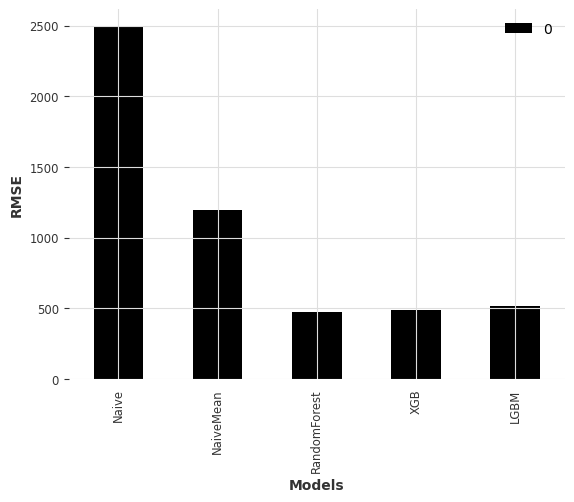

In [28]:
print(f"RMSE for Naivemean forecast: {rmse_backtest_naivemean}")
print(f"RMSE for Naive forecast: {rmse_backtest_naive}")
print(f"RMSE for RandomForest forecast: {rmse_backtest_xgb}")
print(f"RMSE for RandomForest forecast: {rmse_backtest_rf}")
print(f"RMSE for LGBM forecast: {rmse_backtest_lgbm}")

df = pd.DataFrame({'Naive': rmse_backtest_naive, 'NaiveMean': rmse_backtest_naivemean, 'RandomForest': rmse_backtest_rf, 'XGB': rmse_backtest_xgb, 'LGBM': rmse_backtest_lgbm}, index=[0])
ax = df.T.plot(kind='bar')  # Transpose DataFrame before plotting
ax.set_xlabel("Models")
ax.set_ylabel("RMSE")
plt.show()

## Prognozy testowe

In [29]:
# create predictions for test set
rf_model.fit( y_sku_t, future_covariates=future_cov_all)


RandomForest(lags=7, lags_past_covariates=None, lags_future_covariates=[0], output_chunk_length=1, add_encoders={'cyclic': {'future': ['dayofweek', 'month', 'weekofyear', 'quarter']}}, n_estimators=10, max_depth=None, multi_models=True, use_static_covariates=True)

In [30]:
rf_forecast = rf_model.predict(n=7, series=y_sku_t, future_covariates=future_cov_all)


In [31]:
forecastT = transformer.inverse_transform(rf_forecast)

In [32]:
df_forecast = pd.DataFrame()
for (number, time_series) in enumerate(forecastT):
    family_forecast = time_series.pd_dataframe().reset_index()
    family_forecast['family'] = time_series.static_covariates['family'].values[0]
    df_forecast = pd.concat([df_forecast, family_forecast])
    
    

In [33]:
df_forecast

component,date,sales,family
0,2017-08-07,4.40000,AUTOMOTIVE
1,2017-08-08,4.80000,AUTOMOTIVE
2,2017-08-09,3.40000,AUTOMOTIVE
3,2017-08-10,4.40000,AUTOMOTIVE
4,2017-08-11,5.30000,AUTOMOTIVE
...,...,...,...
2,2017-08-09,27.94290,SEAFOOD
3,2017-08-10,23.26167,SEAFOOD
4,2017-08-11,35.24054,SEAFOOD
5,2017-08-12,26.30810,SEAFOOD


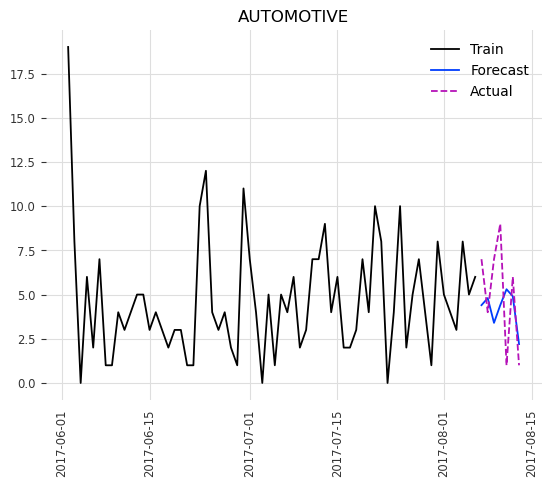

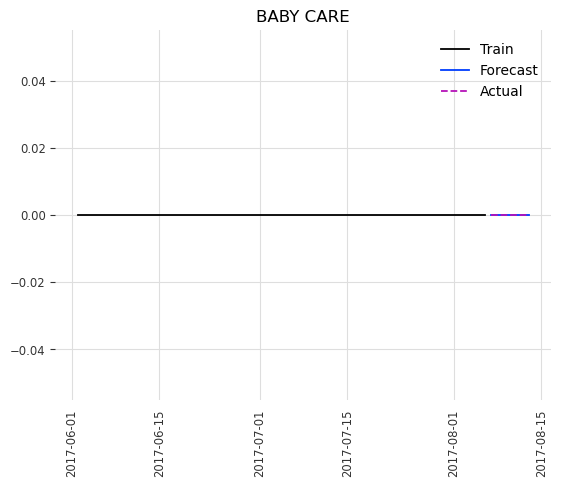

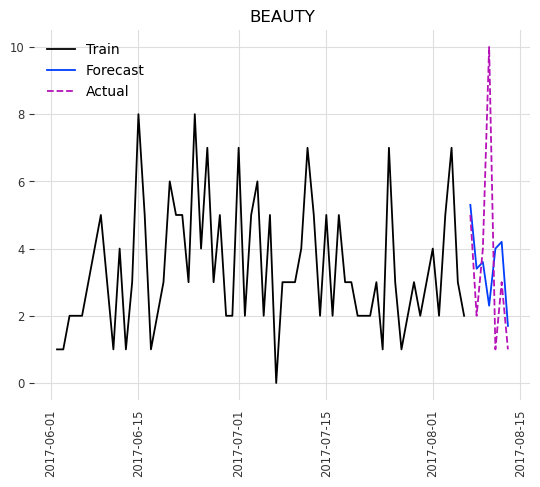

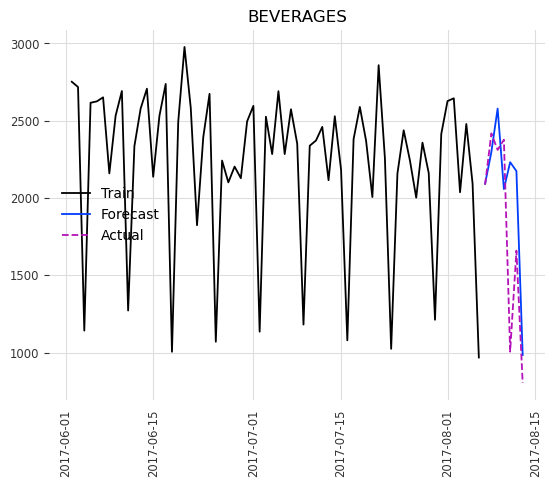

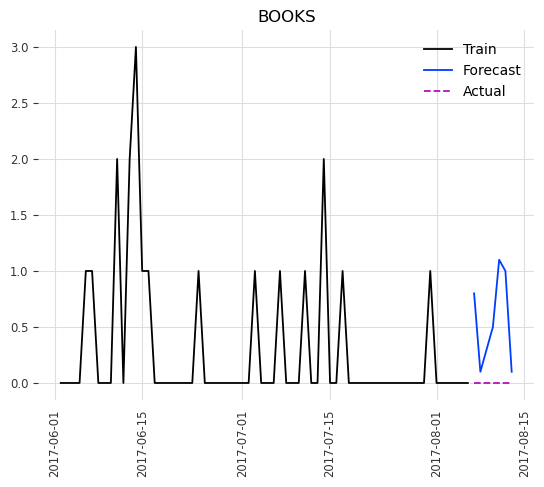

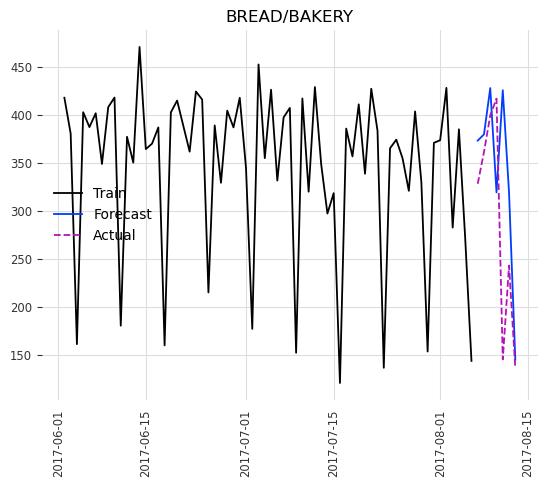

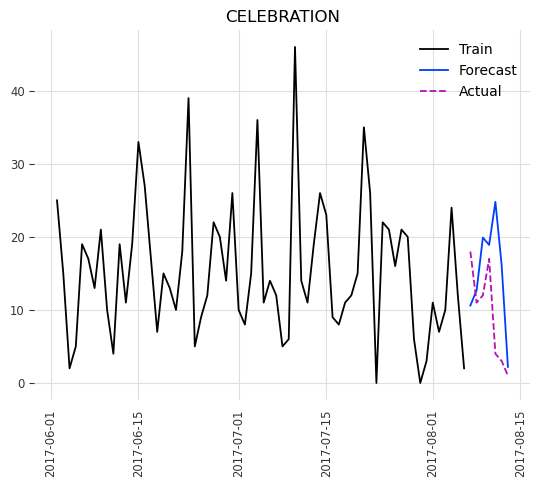

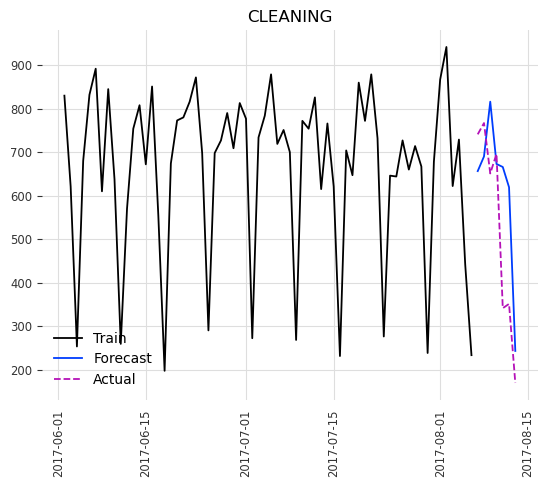

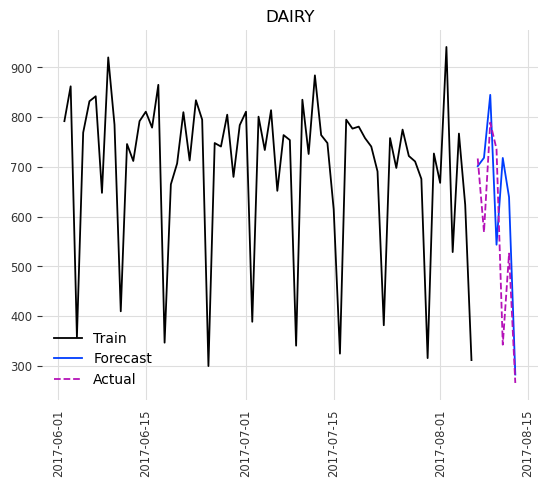

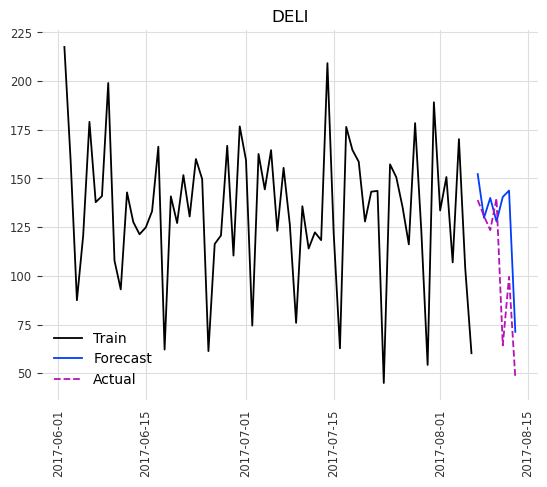

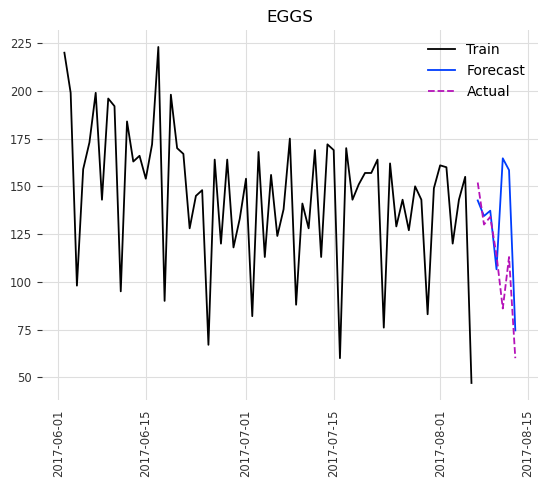

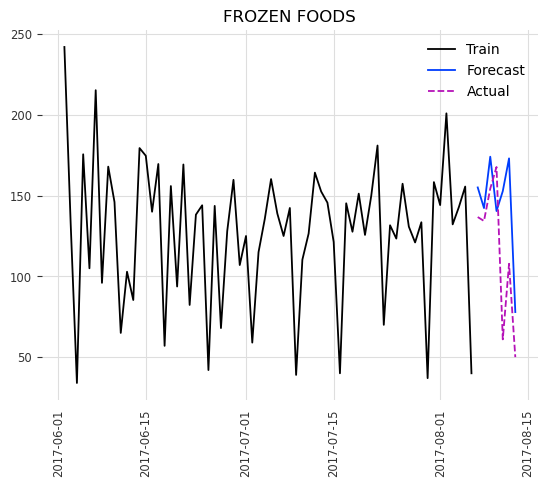

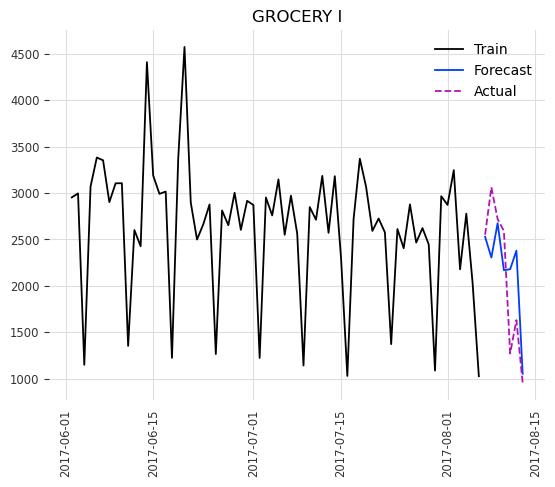

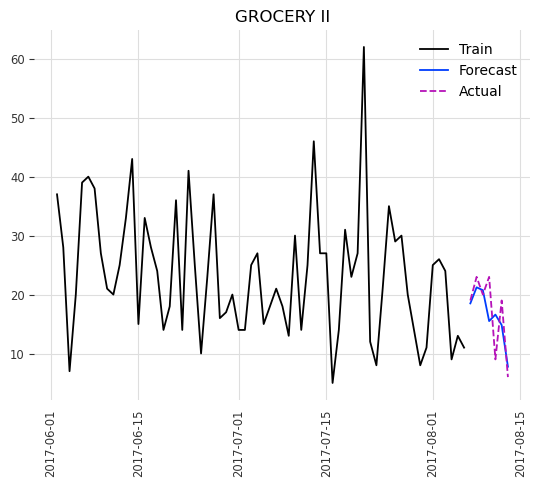

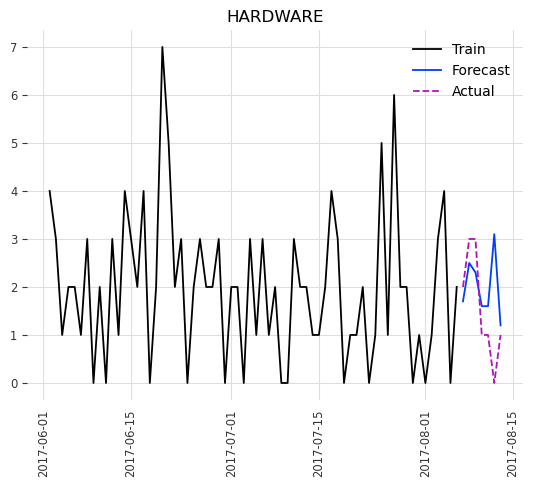

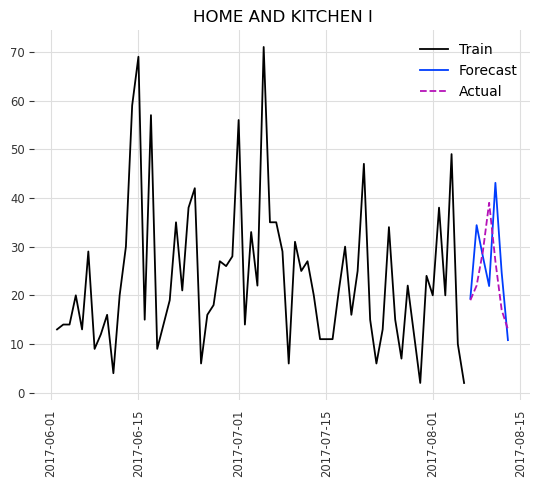

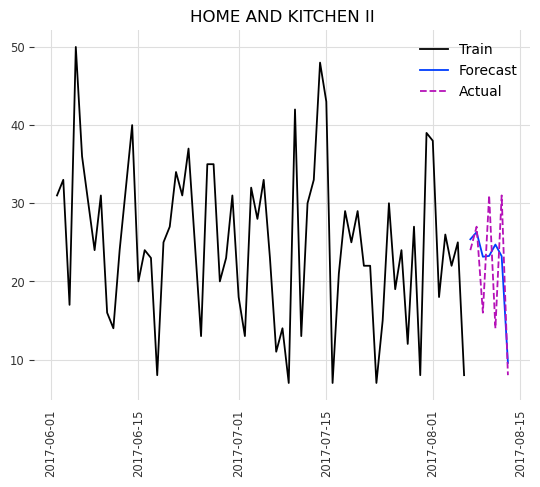

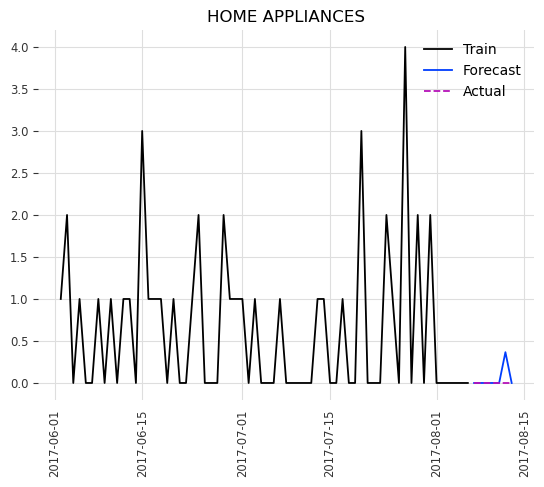

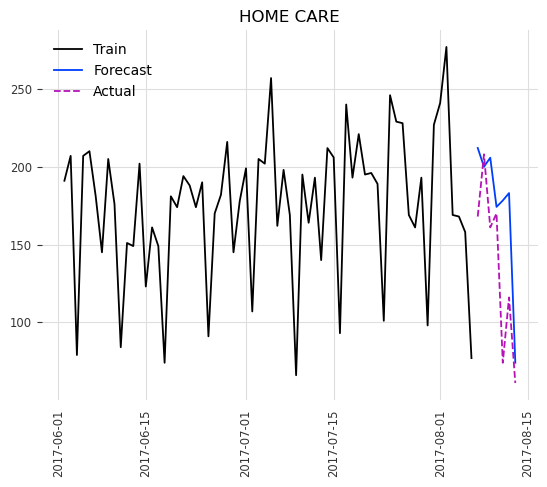

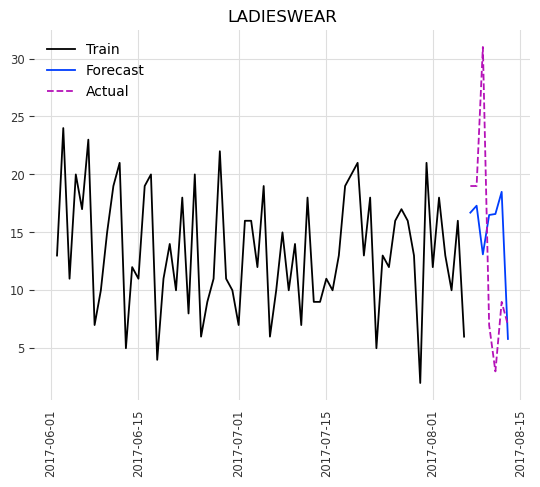

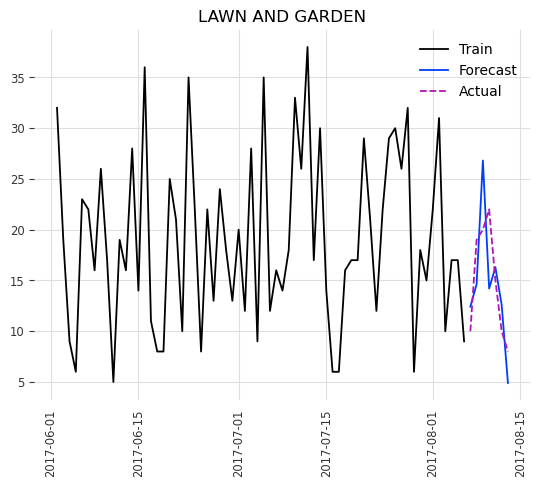

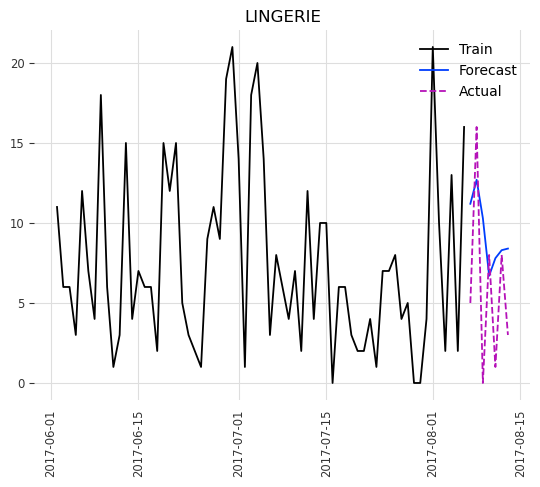

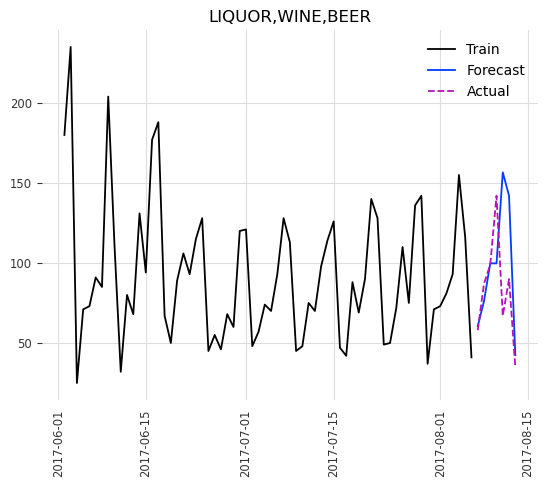

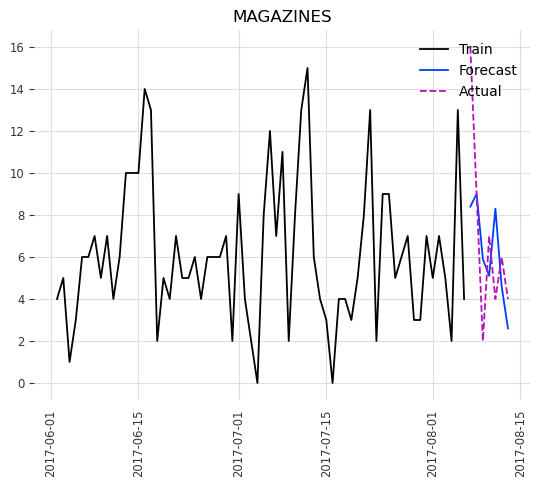

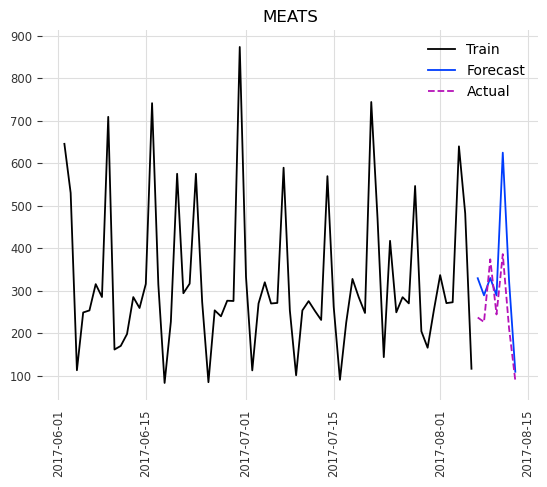

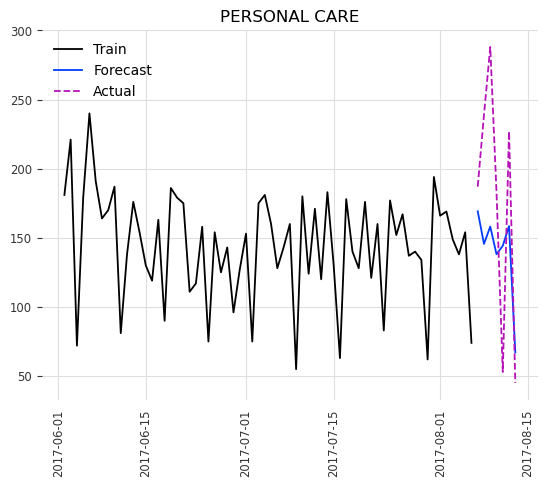

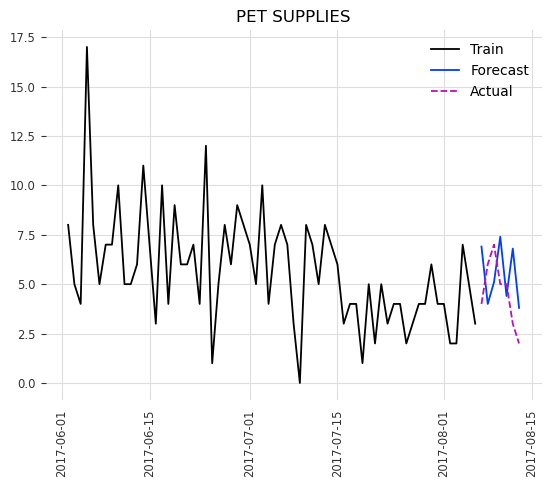

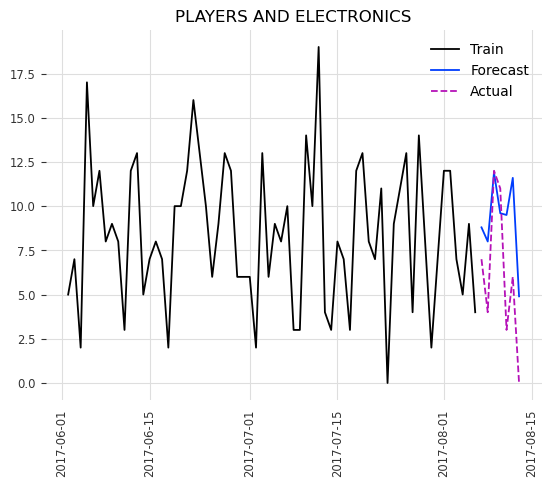

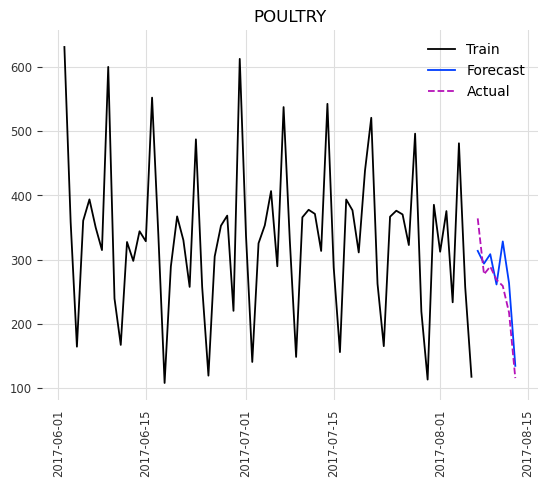

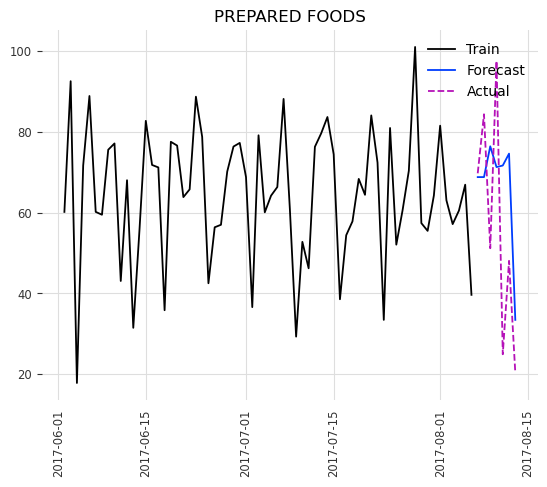

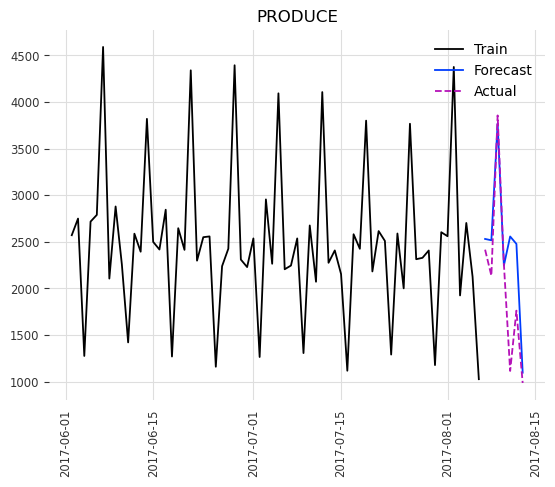

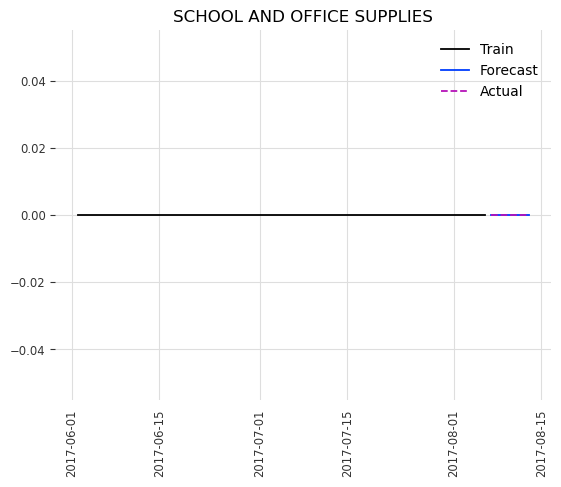

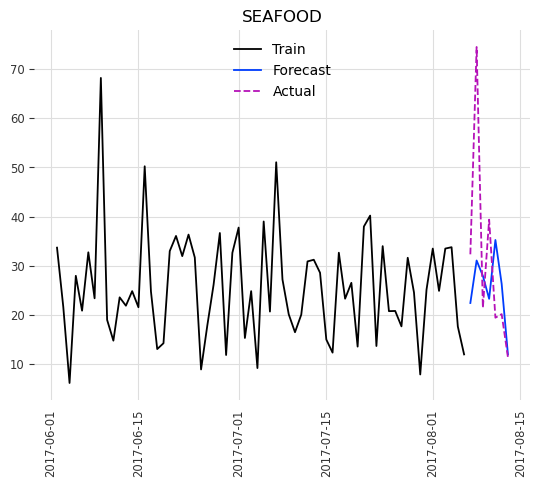

In [34]:
# plot forecast for every family with test set
for family in df_forecast['family'].unique():
    family_train = train[(train['family']==family) & (train['date'] > pd.to_datetime('2017-06-01'))]    
    plt.plot(family_train['date'], family_train['sales'], label="Train")

    plt.plot(df_forecast[df_forecast['family']==family]['date'], df_forecast[df_forecast['family']==family]['sales'], label="Forecast")
    plt.plot(test[test['family']==family]['date'], test[test['family']==family]['sales'], label="Actual", linestyle='dashed')
    plt.title(family)
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

In [35]:

df_forecast = df_forecast.merge(test[['date', 'family', 'sales']], on=['date', 'family'], how='left', suffixes=('', '_test'))
df_forecast.columns = ['date', 'forecast_sale', 'family', 'sales']

In [36]:
df_forecast.columns 

Index(['date', 'forecast_sale', 'family', 'sales'], dtype='object')

In [37]:
from sklearn.metrics import mean_squared_error

# calculate RMSE for every family
rmse = {} 
for family in df_forecast['family'].unique():
    rmse[family] = mean_squared_error(df_forecast[df_forecast['family']==family]['sales'], df_forecast[df_forecast['family']==family]['forecast_sale'], squared=False)


In [38]:
df_rmse = pd.DataFrame(rmse.items(), columns=['family', 'rmse'])

df_forecast_grouped = df_forecast.groupby('family').agg({'sales':'sum', 'forecast_sale':'sum'}).reset_index().rename(columns={'sales':'mean_sales', 'forecast_sale':'mean_forecast_sales'})
df_rmse = df_rmse.merge(df_forecast_grouped, on='family', how='left')

### RMSE dla każdej rodziny produktowej

In [50]:
df_rmse['forecast/sales'] = df_rmse['mean_forecast_sales'] / df_rmse['mean_sales']
df_rmse.sort_values(by='forecast/sales', ascending=False)


,family,rmse,mean_sales,mean_forecast_sales,forecast/sales
4,BOOKS,0.68,0.00,3.90,inf
17,HOME APPLIANCES,0.14,0.00,0.37,inf
21,LINGERIE,5.76,41.00,65.40,1.60
6,CELEBRATION,10.21,66.00,105.20,1.59
27,PLAYERS AND ELECTRONICS,4.12,43.00,64.30,1.50
24,MEATS,111.09,1766.51,2294.07,1.30
18,HOME CARE,52.89,958.00,1227.48,1.28
14,HARDWARE,1.26,11.00,14.00,1.27
11,FROZEN FOODS,46.27,811.82,1015.53,1.25
9,DELI,35.68,744.40,905.50,1.22
